In [374]:
import pandas as pd
import re
import numpy as np

peace1 = pd.read_csv("Data/tweets_with_hashtag_SayNoToWar.csv")
peace2 = pd.read_csv("Data/tweets2_with_hashtag_SayNoToWar.csv") 
peace3 = pd.read_csv("Data/tweets3_with_hashtag_SayNoToWar.csv") 
peace4 = pd.read_csv("Data/tweets4_with_hashtag_SayNoToWar.csv") 
war = pd.read_csv("Data/tweets_with_hashtag_FinalStrike.csv")

peace = peace1.iloc[:,1:].append(peace2.iloc[:,1:]).append(peace3.iloc[:,1:]).append(peace4.iloc[:,1:])

# peace.to_csv("Data/SayNoToWar.csv")
# war.to_csv("Data/FinalStrike.csv")

In [360]:
def get_mentioned_user(y):
    print(re.split(r'\s@(\w+):',y))
    return(0)

def get_mentions_sent(y):
    if len(y)>0:
        return(len(y)-1)
    else:
        return(0)
    
def get_content_type(y):
    if len(y)>0:
        return('RT')
    else:
        return('Tweet')
    
def find_location(df):
    df['country'] = np.where(df.location.notna(), df.location.apply(lambda x: str(x).split(',')[-1].strip().lower()),'No location')
    df['urdu'] = df.text.apply(lambda x: len(re.findall(r'[\u0600-\u06ff]+',x))>0)
    df.loc[df.urdu==1,'country'] = 'pakistan' 
    df['devanagari'] = df.text.apply(lambda x: len(re.findall(r'[\u0900-\u097f]+',x))>0)
    df.loc[df.devanagari==1,'country'] = 'india'
   
    df['pak_present'] = df.country.apply(lambda x: len(re.findall(r'pakistan',x))>0)
    df.loc[df.pak_present==1,'country'] = 'pakistan' 
    df['ind_present'] = df.country.apply(lambda x: len(re.findall(r'india',x))>0)
    df.loc[df.ind_present==1,'country'] = 'india'
    
    return df

def data_clean(df):
    df['retweeted_user']=df.text.apply(lambda x:''.join(re.findall(r'\s@(\w+):',x)))
    df['mentioned_user']= df.text.apply(lambda x:re.findall(r'\s@(\w+)',x))
    df['mentions_sent'] = df.mentioned_user.apply(get_mentions_sent)
    df['retweets_sent'] = df.retweeted_user.apply(lambda x: int(len(x)>0))
    df['content_type'] = df.retweeted_user.apply(get_content_type)
    df['date'] = pd.to_datetime(df.created_at).apply(lambda x: str(x.date()))
    df = find_location(df)
    df.drop(['ids','text','location','urdu','devanagari','pak_present','ind_present'],axis=1,inplace=True)
    df = df[df['retweets_sent']==1]
    return df

In [361]:
peace = data_clean(peace)
war = data_clean(war)

In [362]:
peace.head()

,retweet,favorite,inreplyto,friends,screen_name,followers,listed,created_at,retweeted_user,mentioned_user,mentions_sent,retweets_sent,content_type,date,country
0,38,0,NaN,561,imshee67,9924,18,2019-02-25 23:39:20,TahirMujtaba_,[TahirMujtaba_],0,1,RT,2019-02-25,pakistan
1,1,0,NaN,24,SyedHas70245685,0,0,2019-02-25 22:51:47,Shaistayousuff,[Shaistayousuff],0,1,RT,2019-02-25,pakistan
2,38,0,NaN,573,tabankhamosh,1064,11,2019-02-25 22:49:37,TahirMujtaba_,[TahirMujtaba_],0,1,RT,2019-02-25,pakistan
6,38,0,NaN,554,Uzair_Afaq,2261,25,2019-02-25 19:38:39,TahirMujtaba_,[TahirMujtaba_],0,1,RT,2019-02-25,pakistan
7,38,0,NaN,876,Malang9111,2034,21,2019-02-25 19:28:53,TahirMujtaba_,[TahirMujtaba_],0,1,RT,2019-02-25,pakistan


In [363]:
india_first1000 = peace[peace.country=='india'].sort_values(by = ['created_at'])[:1000]

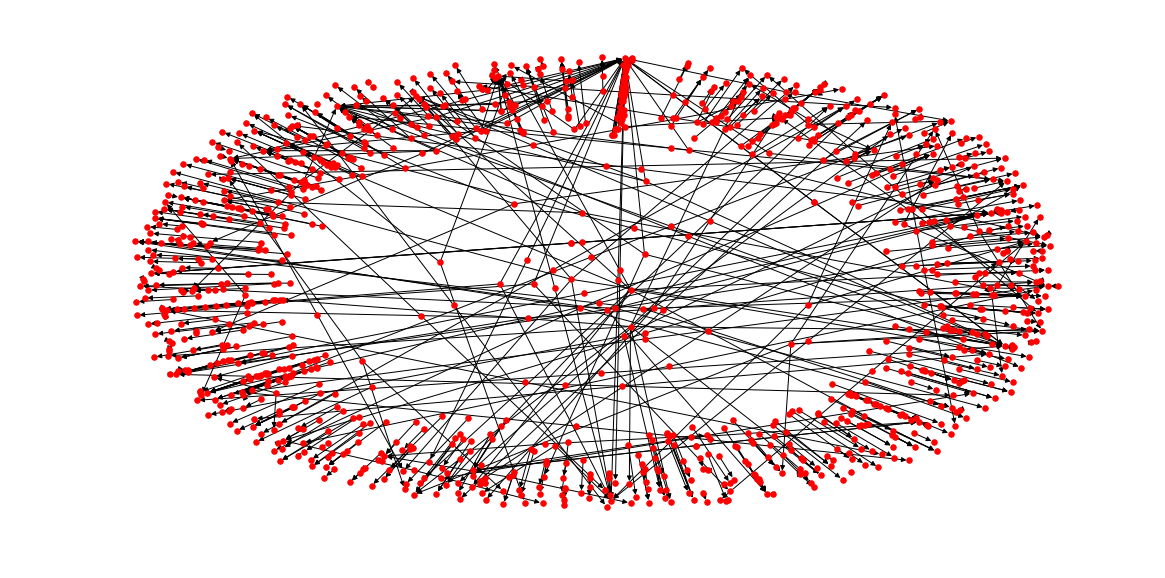

In [364]:
import networkx as nx
from networkx.algorithms import approximation
import matplotlib
from matplotlib import pyplot as plt 
%matplotlib inline

india_first1000 = india_first1000.sort_values(by=['screen_name'])
g = nx.from_pandas_edgelist(india_first1000, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

plt.figure(1,figsize=(20,10)) 
nx.draw_networkx(g,with_labels = False, node_size = 30,pos=nx.spring_layout(g))
plt.axis('off')
plt.show()

# nodelist (list, optional (default G.nodes())) – Draw only specified nodes
# edgelist (list, optional (default=G.edges())) – Draw only specified edges

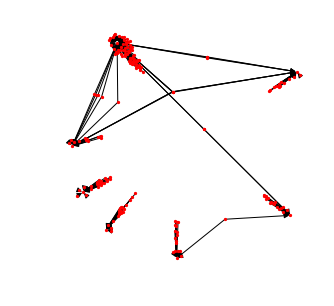

In [365]:
deg = dict(g.in_degree())
to_remove = [n for n in deg.keys() if deg[n] <= 16]
sub = [nodes for nodes in g.nodes() if nodes not in to_remove]
influencers = india_first1000[(india_first1000.screen_name.isin(sub)) | (india_first1000.retweeted_user.isin(sub))]


F = nx.from_pandas_edgelist(influencers, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

plt.figure(1,figsize=(5,5)) 
nx.draw_networkx(F,with_labels = False, node_size = 5,pos=nx.spring_layout(F))
plt.axis('off')
plt.show()

In [366]:
influencers.retweeted_user.value_counts()

abhijitmajumder    79
KaranGandhi28      22
MasalaBai          20
VanzaraDg          19
rishibagree        19
ShefVaidya         19
PrashantKishor     18
Name: retweeted_user, dtype: int64

## Initial tweets

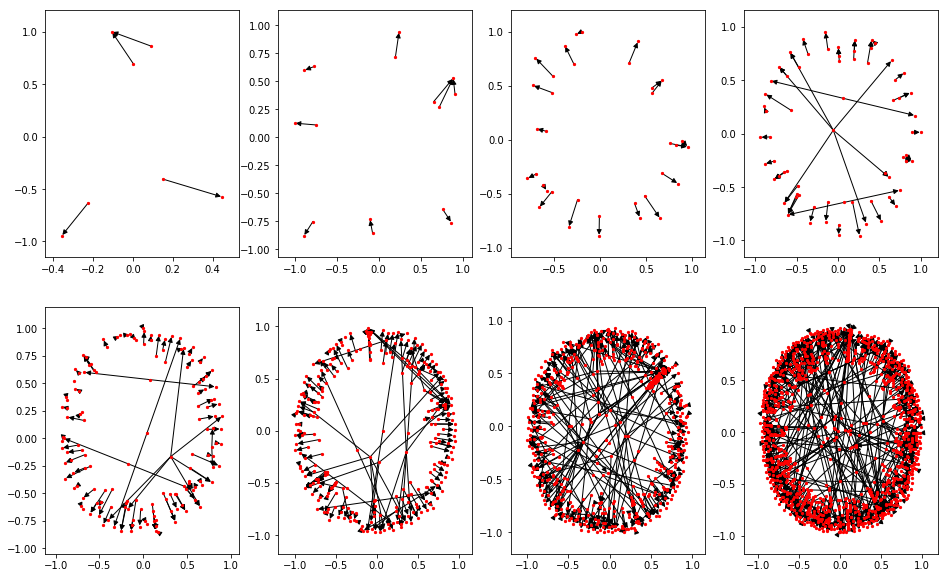

In [367]:
fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(nrows=2,ncols=4,figsize=(16, 10))

india_first500 = peace[peace.country=='india'].sort_values(by = ['created_at'])[:5]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax1)


india_first500 = peace[peace.country=='india'].sort_values(by = ['created_at'])[:10]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax2)

india_first500 = peace[peace.country=='india'].sort_values(by = ['created_at'])[:20]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax3)

india_first500 = peace[peace.country=='india'].sort_values(by = ['created_at'])[:50]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax4)

india_first500 = peace[peace.country=='india'].sort_values(by = ['created_at'])[:100]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax5)

india_first500 = peace[peace.country=='india'].sort_values(by = ['created_at'])[:200]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax6)

india_first500 = peace[peace.country=='india'].sort_values(by = ['created_at'])[:500]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax7)

india_first500 = peace[peace.country=='india'].sort_values(by = ['created_at'])[:1000]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax8)

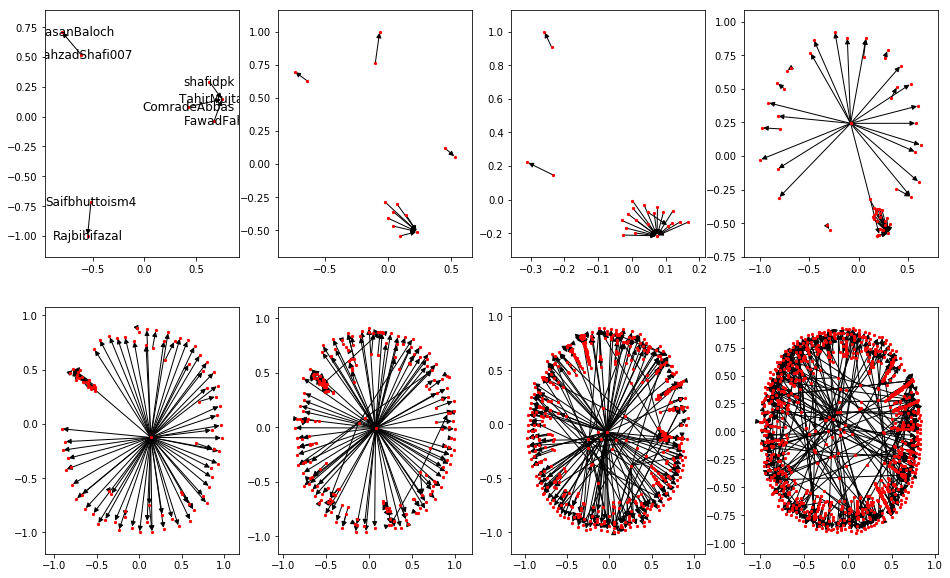

In [369]:
fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(nrows=2,ncols=4,figsize=(16, 10))

india_first500 = peace[peace.country=='pakistan'].sort_values(by = ['created_at'])[:5]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
nx.draw_networkx(F500,with_labels = True, node_size = 5,pos=nx.spring_layout(F500),ax=ax1)


india_first500 = peace[peace.country=='pakistan'].sort_values(by = ['created_at'])[:10]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax2)

india_first500 = peace[peace.country=='pakistan'].sort_values(by = ['created_at'])[:20]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax3)

india_first500 = peace[peace.country=='pakistan'].sort_values(by = ['created_at'])[:50]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())

nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax4)

india_first500 = peace[peace.country=='pakistan'].sort_values(by = ['created_at'])[:100]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
# F500.remove_node('SNangyale')
nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax5)

india_first500 = peace[peace.country=='pakistan'].sort_values(by = ['created_at'])[:200]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
# F500.remove_node('SNangyale')
nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax6)

india_first500 = peace[peace.country=='pakistan'].sort_values(by = ['created_at'])[:500]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
# F500.remove_node('SNangyale')
nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax7)

india_first500 = peace[peace.country=='pakistan'].sort_values(by = ['created_at'])[:1000]
F500 = nx.from_pandas_edgelist(india_first500, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
F500.remove_node('SNangyale')
nx.draw_networkx(F500,with_labels = False, node_size = 5,pos=nx.spring_layout(F500),ax=ax8)

In [292]:
deg = dict(F500.out_degree())
vie = pd.DataFrame(deg,index = ['out_degree']).T.sort_values(by = 'out_degree',ascending=False)
vie.head()
# sub = [nodes for nodes in g.nodes() if nodes not in to_remove]

,out_degree
Rahim_Realist,14
waleedmughalpti,8
danishusmani16,5
ubaidyamin,4
Nayab_fatima7,4


In [296]:
peace[peace.country=='india'].sort_values(by = ['created_at'])[:50][['screen_name','retweeted_user']].head()

,screen_name,retweeted_user
65,vimalverma558,
64,VinayKumarjehan,vimalverma558
63,vimalverma558,vimalverma558
60,sarikaksharma,PoojaVAlexander
59,sadiq_zaf,


In [373]:
F500 = nx.from_pandas_edgelist(peace, source='screen_name', target='retweeted_user'
                            ,edge_attr = 'retweets_sent',create_using=nx.DiGraph())
centrality = pd.DataFrame(nx.katz_centrality(F500),index = ['Katz_centrality']).T.sort_values(by = 'Katz_centrality',ascending = False)
centrality[:10]

,Katz_centrality
abhijitmajumder,0.182531
Malala,0.161682
_SJPeace_,0.135478
MJibranNasir,0.135478
KhaleejMag,0.128987
ArmeenaRK,0.121849
PTIofficial,0.117225
MasalaBai,0.107166
siasatpk,0.105543
realpreityzinta,0.102542
